# Airbee data checking
- daily 데이터를 확인하는 프로세스

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

%matplotlib inline 
%config InlineBackend.figure_format = 'retina' 

sns.set_style(style='white')
sns.set_context(context ='paper')

pd.set_option('max_columns',50)
pd.set_option('max_rows',500)

font_path = 'NanumSquareRoundR.ttf'
fontprop = fm.FontProperties(fname=font_path, size = 15)

pd.set_option('display.max_columns',999)
pd.set_option('display.max_rows',999)

### 실외 데이터 업로드

In [2]:
out1022 = pd.read_csv('day22_out.csv', encoding = 'euc-kr')
out1105 = pd.read_csv('day1105.csv',encoding = 'CP949')

### 야쿠르트, T-world 매장 데이터 업로드

In [3]:
tworld_data = pd.read_csv('tworld.csv')
tworld_location = pd.read_csv('tworld_location.csv', encoding = 'euc-kr')
yakult_data= pd.read_csv('yakult.csv')
yakult_location= pd.read_csv('yakult_location.csv',encoding = 'euc-kr')

### 실외데이터 전처리

In [4]:
# xtick 그리기
xtick = list()

for i in range(24):
    xtick.append(str(i+1))

In [5]:
def preprocessing_1(out):
    
    out.columns = ['SENSOR_ID', 'MEASURE_DTTM', 'LAT',
               'LON', 'TOTAL_ADDR', 'PM1',
               'PM2', 'PM10', 'TEMPER',
               'HUMI', 'TVOC', 'CO2',
               'FORMALDEHYDE', 'BATTERY_INFO', 'SPEED',
               'ILLUMINATION', 'ACCELERATE', 'USE_YN']   
    out.dropna(subset = ['TOTAL_ADDR','PM2'], inplace = True)
    out.reset_index(drop = True, inplace = True)
    
    def year(x):
        return int(x.split(' ')[0].split('-')[0])
        
    out['PARTITION_YEAR'] = out.MEASURE_DTTM.map(year)

    def month(x):
        return int(x.split(' ')[0].split('-')[1])
        
    out['PARTITION_MONTH'] = out.MEASURE_DTTM.map(month)

    def day(x):
        return int(x.split(' ')[0].split('-')[2])
        
    out['PARTITION_DAY'] = out.MEASURE_DTTM.map(day)
    
    def region_1(x):
        return x.split(' ')[0]
    
    out['CITY'] = out.TOTAL_ADDR.map(region_1)
    
    def region_2(x):
        return x.split(' ')[1]
    
    out['GUNGU'] = out.TOTAL_ADDR.map(region_2)
    
    out = out.reset_index(drop = True)

In [6]:
preprocessing_1(out1022)

In [7]:
def preprocessing_2(out):
    def year(x):
        return int('20' + x.split(' ')[0].split('/')[0])
    out['PARTITION_YEAR'] = out.MEASURE_DTTM.map(year)
    
    def month(x):
        return int(x.split(' ')[0].split('/')[1])
    out['PARTITION_MONTH'] = out.MEASURE_DTTM.map(month)
    
    def day(x):
        return int(x.split(' ')[0].split('/')[2])
    out['PARTITION_DAY'] = out.MEASURE_DTTM.map(day)

In [8]:
preprocessing_2(out1105)

In [9]:
out1105.head(1)

,SENSOR_ID,MEASURE_DTTM,PARTITION_HOUR,USER_UNIQUE_KEY,INPUT_TYPE,CONNECT_TYPE,PARTNER_YN,LAT,LON,LEGAL_DONG_CD,TOTAL_ADDR,CITY,GUNGU,DONG,BUNJI,DETAIL_ADDR,BUILDING_NM,SHOP_NM,PM1,PM2,PM10,TEMPER,HUMI,TVOC,CO2,FORMALDEHYDE,BATTERY_INFO,SPEED,BUILDING_SEQ,ROAD_NM,ROAD_NM_TOTAL_ADDR,PARTNER_SEQ,ILLUMINATION,ACCELERATE,USE_YN,REG_DTTM,MOD_DTTM,GEOM,PARTITION_YEAR,PARTITION_MONTH,PARTITION_DAY
0,A4C1385C6BCD,00/10/17 14:19:00.000000000,14,2672ebc251374e8a91bb38a4434ef0c8,100,200,N,37.511239,127.085383,1.171010e+09,서울특별시 송파구 잠실동 184-8,서울특별시,송파구,잠실동,184-8,NaN,NaN,NaN,14,32,41,16,28,NaN,NaN,NaN,100,2,NaN,올림픽로,서울특별시 송파구 올림픽로 132,NaN,11,1,Y,18/10/17 14:19:17.000000000,18/10/17 14:19:17.000000000,"MDSYS.SDO_GEOMETRY(2001, 8307, MDSYS.SDO_POINT...",2000,10,17


### 야쿠르트, T-world 매장 데이터 전처리

In [10]:
yakult = pd.merge(yakult_location, yakult_data, how = 'left')

In [11]:
tworld = pd.merge(tworld_data, tworld_location, how='inner')

### 제휴사
- PARTNER_SEQ 에서 61이 t-world, 41이 야쿠르트

### 함수

In [12]:
# tworld 매장 이상 수치
def tworld_toomuch_PM2(out, year, month, day, region, limit,number):
    tworld_temp = out[lambda x : (x.PARTNER_SEQ==61)& (x.CITY==region)& (x.PM2 > limit) & (x.PARTITION_DAY == day) &(x.PARTITION_MONTH == month)&(x.PARTITION_YEAR == year)]
    tworld_temp_merge = pd.merge(tworld_temp,tworld, how='left', on='SENSOR_ID')
    count = tworld_temp_merge.매장명.value_counts()
    df = pd.DataFrame(count)
    df.columns = ['데이터수']
    df = df[df.데이터수 > number]
    return df.index

In [13]:
# 시도별 지역 보기
def city(out):
    return out.CITY.unique()

In [14]:
# tworld 데이터 갯수
def daily_tworld_data_count(out,year,month,day,region):
    out_temp = out[lambda x : (x.PARTNER_SEQ==61)&(x.PARTITION_YEAR==year)&(x.PARTITION_MONTH==month)&(x.PARTITION_DAY==day)&(x.CITY==region)]
    temp_tworld = pd.merge(out_temp, tworld, how ='outer')
    count = temp_tworld.매장명.value_counts()
    df = pd.DataFrame(count)
    df.columns = ['데이터수']
    def zero(x):
        if x == 1:
            return 0
        else:
            return x
    df['데이터수'] = df['데이터수'].map(zero)
    return df[df.데이터수 < 144]

In [15]:
# 지점별 코코 한대 당 데이터 갯수
def daily_yakult_data_count_average(data,year,month,day,store):
    data = data[lambda x : (x.PARTITION_YEAR==year) & (x.PARTITION_MONTH==month) & (x.PARTITION_DAY==day)]
    temp_df = pd.merge(yakult, data, how='right')
    temp = temp_df[lambda x: x.지점 == store].영업점.value_counts()/yakult[lambda x: x.지점 == store].영업점.value_counts()
    plt.figure(figsize = (15,6))
    a = (temp).plot.bar(color='0.5')

    sns.despine()
    plt.tick_params(labelsize=15) 
    a.set_ylabel('갯수',fontproperties=fontprop)
    a.set_xlabel('영업점',fontproperties=fontprop)
    a.set_xticklabels(temp.index,fontproperties=fontprop)
    a.axhline(np.mean(temp),color = 'g')
    plt.text(len(temp),np.mean(temp),'전체평균',fontproperties=fontprop)
    plt.title('지점별 코코 1대당 {}년 {}월 {}일 데이터 갯수 (평균)'.format(year,month,day),fontproperties=fontprop,fontsize=20)
    plt.grid(False)
    plt.show()

In [16]:
def store():
    return yakult.지점.unique()

In [17]:
# 지점별
def daily_yakult_data_count_airbee1(data,year,month,day,store):
    data = data[lambda x : (x.PARTITION_YEAR==year) & (x.PARTITION_MONTH==month) & (x.PARTITION_DAY==day)]
    temp_df = pd.merge(yakult, data, how='outer')
    temp_df = temp_df[lambda x : x.지점 == store]
    temp = temp_df.groupby(['영업점','이름'])['ID'].count()
    df = pd.DataFrame(temp)
    df.columns = ['데이터수']
    def zero(x):
        if x == 1:
            return 0
        else:
            return x
    df['데이터수'] = df['데이터수'].map(zero)
    return df

In [18]:
def daily_yakult_data_count_airbee2(data,year,month,day,store1,store2):
    data = data[lambda x : (x.PARTITION_YEAR==year) & (x.PARTITION_MONTH==month) & (x.PARTITION_DAY==day)]
    temp_df = pd.merge(yakult, data, how='outer')
    temp_df = temp_df[lambda x : (x.지점 == store1)&(x.영업점 == store2)]
    temp = temp_df.groupby(['이름'])['ID'].count()
    df = pd.DataFrame(temp)
    df.columns = ['데이터수']
    def zero(x):
        if x == 1:
            return 0
        else:
            return x
    df['데이터수'] = df['데이터수'].map(zero)
    return df

In [19]:
def region_graph(out, year, month, day, region1):
    temp = out[(out.CITY == region1)&(out.PARTITION_YEAR==year) & (out.PARTITION_MONTH==month) & (out.PARTITION_DAY==day)]
    xticks = temp.GUNGU.value_counts().index
    plt.figure(figsize = (15,6))
    a = temp.GUNGU.value_counts().plot.bar(color='0.5')
    sns.despine()
    plt.tick_params(labelsize=10) 
    a.set_xticklabels(xticks,fontproperties=fontprop, fontsize = 15)
    plt.xlabel('지역',fontproperties=fontprop)
    plt.ylabel('데이터 갯수',fontproperties=fontprop)
    plt.title('{}년 {}월 {}일 {} 데이터 갯수'.format(year,month, day, region1),fontproperties=fontprop, fontsize = 20)
    plt.grid(False)
    plt.show()

# T-world

## T-world 펌웨어 업데이트 미완료 매장 추정

- city(실외데이터)
- tworld_toomuch_PM2(실외데이터, 년, 월, 일, '시도', PM2 기준, 해당 기준을 넘는 수치가 측정된 횟수)

In [20]:
city(out1105)

array(['서울특별시', '경기도', '전라북도', '경상남도', '전라남도', '광주광역시', '부산광역시', '강원도',
       nan, '대전광역시', '대구광역시', '제주특별자치도', '인천광역시', '경상북도', '충청북도', '충청남도',
       '울산광역시'], dtype=object)

In [21]:
tworld_toomuch_PM2(out1105, 2018, 11, 5, '서울특별시', 100, 6)

Index(['백마장대리점 신림역점', 'PS&M1 대리점 압구정점', '대림대리점 이수역점', '신창대리점 창동역 직영점',
       '라온대리점 하단점', '서울직영SHOP 어린이대공원점', '가로수직영SHOP 센트라스점', 'PS&M2 대리점 홍제직영점',
       '동진대리점 상암DMC점', 'PS&M2 대리점 상왕십리점', 'MK대리점 마포점', '서울ent대리점 잠실점',
       '광장대리점 방배동점', 'PS&M2 대리점 길동역점', 'PS&M2 대리점 성동점', 'PS&M1 대리점 까치산점',
       '정원대리점 양재역직영점', 'PS&M2 대리점 미아역점', '정릉대리점 성북구청점', '논현대리점 강남교보점',
       'PS&M2 대리점 불광역점', '피앤피대리점 석촌역직영점', 'PS&M2 대리점 구산역점', 'PS&M2 대리점 동대문구청점',
       '한유대리점 관악직영점', 'PS&M2 대리점 은평구청직영점', 'PS&M2 대리점 신촌점', 'PS&M2 대리점 종로3가점'],
      dtype='object')

In [26]:
tworld[lambda x : x.매장명.isin(tworld_toomuch_PM2(out1105, 2018, 11, 5, '서울특별시', 100, 6))][:1]

,ID,SENSOR_ID,신매장코드,마케팅본부,마케팅팀,대리점명,매장명,집중 상가 유동인구 매장,매장특성구분,시/구,주소,연락처,설치센터,관리번호,설치 구분,비고
6,tworld00420,A4C13860189E,D137420154,수도권마케팅본부,강남마케팅팀,한유대리점,한유대리점 관악직영점,NaN,T Premium Store,서울 관악구,서울 관악구 관악로 196 (봉천동 851-19.정상규안과의원),02-6460-8799,서비스엔 강서센터,420,설치완료,NaN


In [72]:
tworld['설치 구분'].unique()

array(['설치완료', nan, '설치불가'], dtype=object)

## T-world 데이터 갯수

- 24 * 6 = 144 개 -> 144개 이하인 지점 보여줌
<br>

- daily_tworld_data_count(실외데이터,년,월,일,'시도별')

In [27]:
daily_tworld_data_count(out1105,2018,11,4,'서울특별시')[:1]

,데이터수
서울ent대리점 잠실점,143


# 야쿠르트

- 서비스 초반이라 이런 형식으로 어느 정도 관리할 수는 있으나 추후 개발을 통해 대시보드로 관리 or 다른 형식의 지점 관리 프로세스가 필요해 보임
- 데이터의 형식이 달라지는 경우가 존재할 수 있으므로 이 파일이 계속해서 유효할 것이라는 것은 어려움

## 야쿠르트 지점별 실외데이터 갯수
- 지점별 일일 실외데이터 갯수 / 코코 갯수 => 코코 1대당 일일 데이터 갯수 시각화
<br>
<br>
- 여사님들 지점 + 개개인마다 근무환경이 매우 다름
<br>
-> 데이터의 갯수는 매우 상이할 수 밖에 없음
<br>
-> 따라서 전체평균을 고려 + 어느 정도의 허용범위를 인정해주는 것이 필요
<br>
<br>
- daily_yakult_data_count_average(실외데이터,년,월,일,지점 지역)

In [36]:
store()

array(['강남', '강서', '경원'], dtype=object)

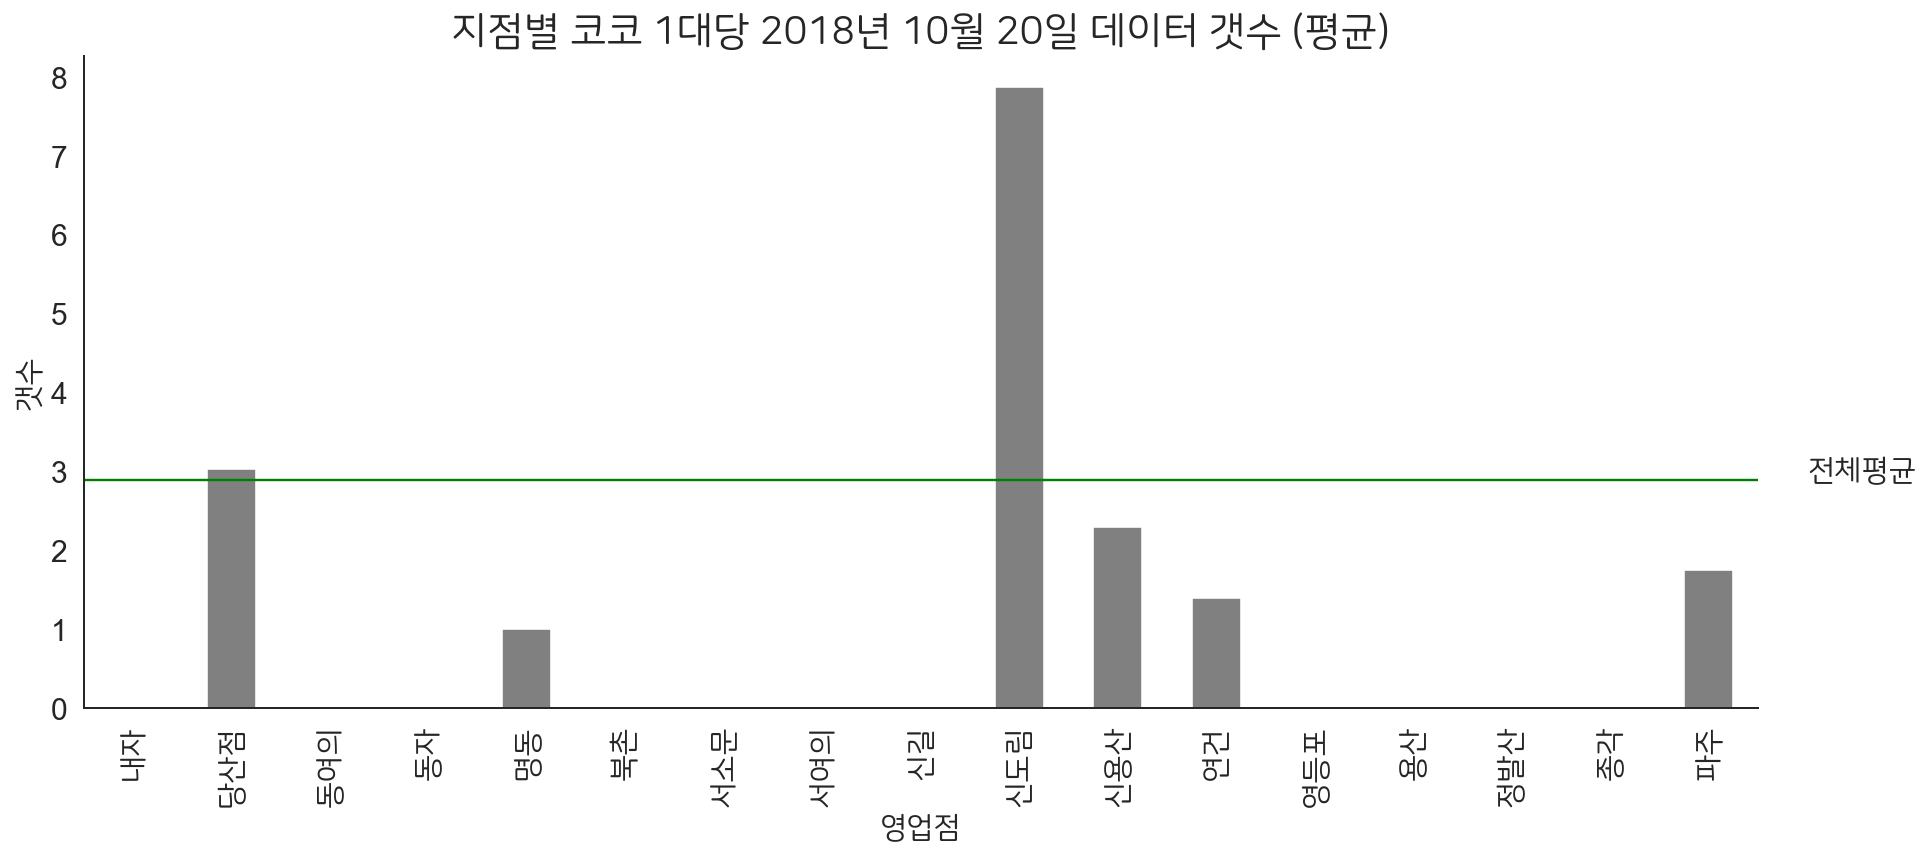

In [31]:
daily_yakult_data_count_average(out1022,2018,10,20,'강서')

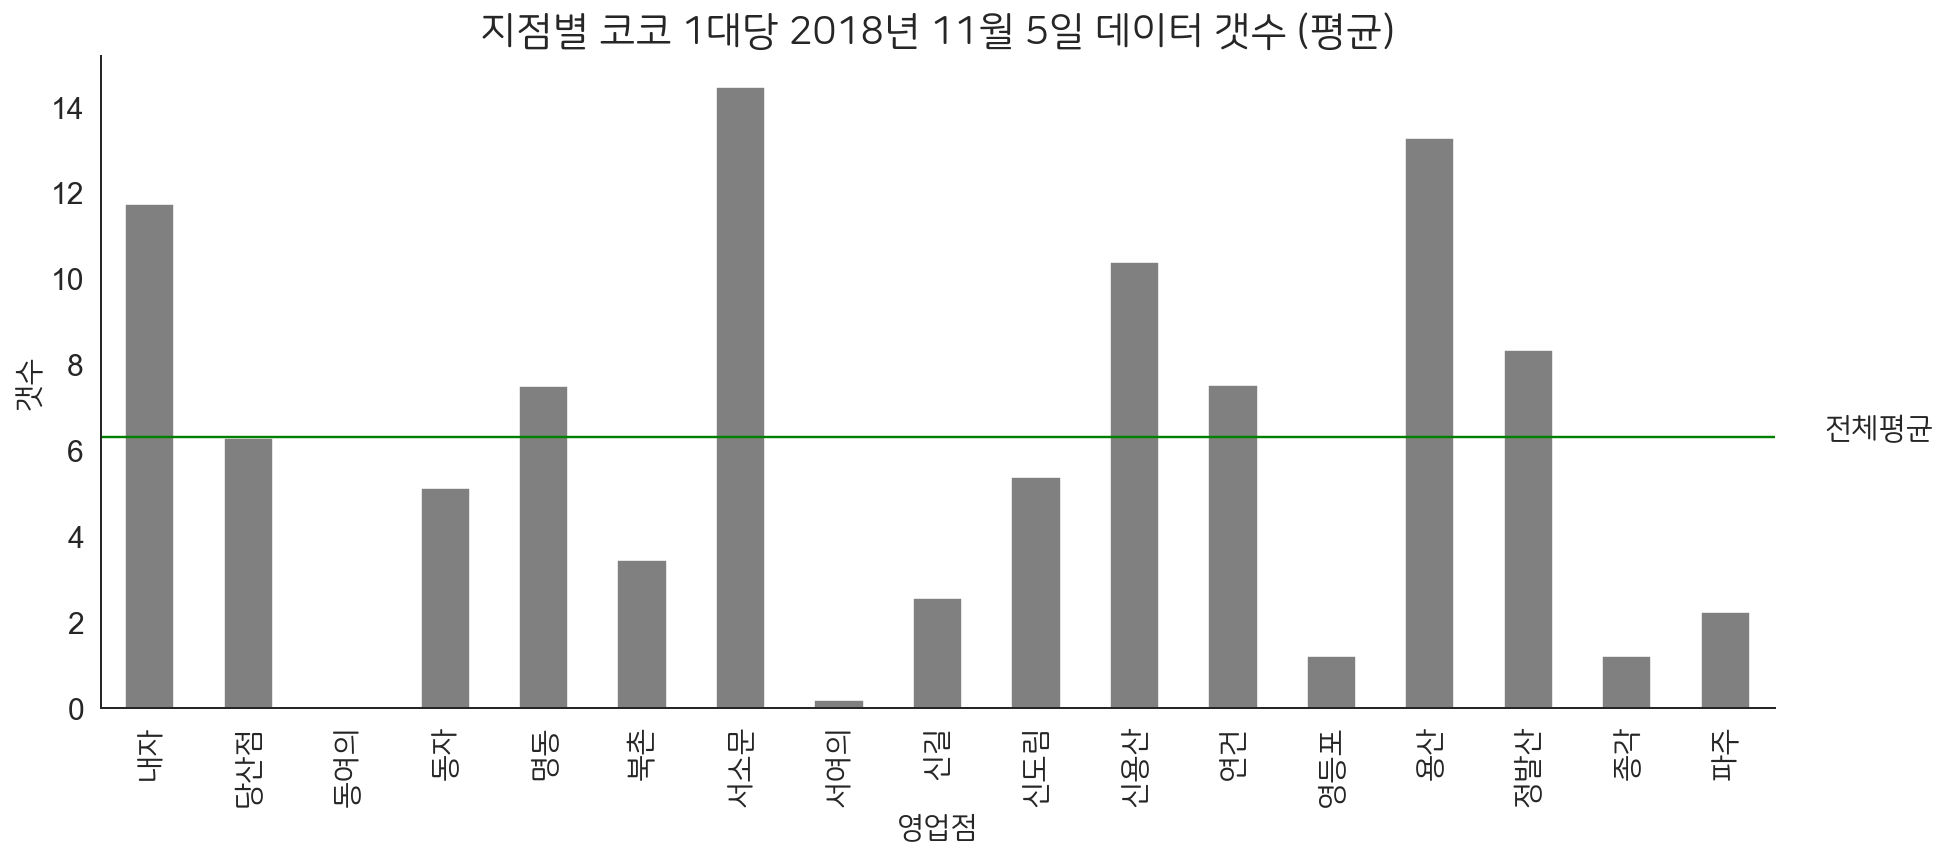

In [34]:
daily_yakult_data_count_average(out1105,2018,11,5,'강서')

## 영업점별 여사님 데이터 카운트

- daily_yakult_data_count_airbee1(실외데이터,년,월,일,'지점지역')
<br>
- daily_yakult_data_count_airbee2(실외데이터,년,월,일,'지점지역','영업점')

In [22]:
store()

array(['강남', '강서', '경원'], dtype=object)

In [28]:
daily_yakult_data_count_airbee1(out1105, 2018, 11, 5, '강남')[:1]

,,데이터수
영업점,이름,
강남,강성숙,0


In [29]:
daily_yakult_data_count_airbee2(out1105, 2018, 11, 5, '강남', '매봉')[:1]

,데이터수
이름,
강옥순,17


## 지역별 데이터 갯수
- 부족한 지역을 파악하여 보완
- 지역별 밸런스 고려
<br>

- city(실외데이터)
- region_graph(실외데이터,년,월,일,'시도별')

In [92]:
def city(out):
    return out.CITY.unique()

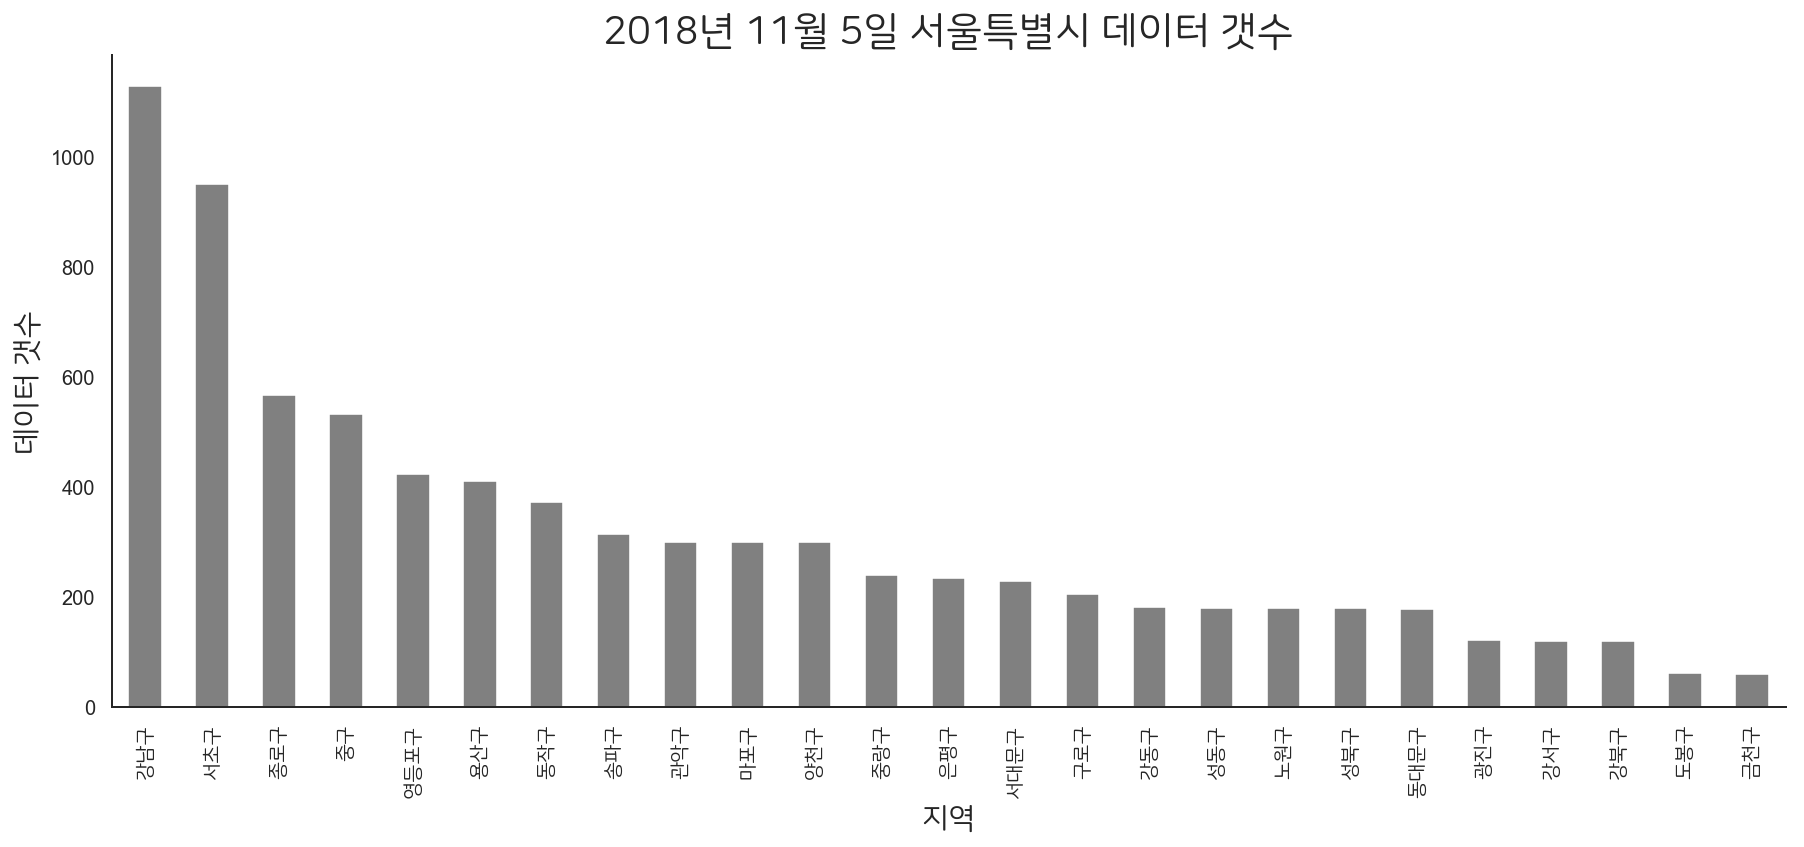

In [94]:
region_graph(out1105,2018,11,5,'서울특별시')